In [1]:
from digipat.data.datasets.examples.bcss import BCSS_OOD_Dataset
from digipat.data.augmentations import *

data = BCSS_OOD_Dataset()
aug = SampledOODAugmentation(DarkSpotsAugmentation(), 0.5)
img, mask, meta = aug(torch.ones(3, 300, 300), torch.ones((300, 300)))
meta


DistributionSampleType.IN_DISTRIBUTION_DATA - {}

In [3]:
from digipat.data.metadata import *

test = init_sample_metadata()
test.type= DistributionSampleType.IN_DISTRIBUTION_DATA
test["type"] = DistributionSampleType.DATASET_OOD_DATA
test.data = {"lko": 3, "type": 50}
test.type

<DistributionSampleType.DATASET_OOD_DATA: 4>

In [1]:
from digipat.ood.strategy import AugmentationStrategy
from digipat.data.datasets.examples.bcss import BCSS_OOD_Dataset
from digipat.data.augmentations import *
from digipat.ood.methods import ODIN, EnergyBased, MaxClassBaseline
from digipat.models.segmantation import SegmentationModel
from digipat.data.metadata import MetadataCommonTypes

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd

strategy = AugmentationStrategy(
    BCSS_OOD_Dataset(),
    SampledOODAugmentation(
        DarkSpotsAugmentation(sample_range={"scale": (0.45, 4.75)}), 0.5
    ),
)
net = SegmentationModel().load()
methods = [MaxClassBaseline(), ODIN(), EnergyBased()]
i = 0
all = []
for img, mask, meta in tqdm.tqdm(strategy.get_dataloader(batch_size=16, num_workers=8)):

    for index, m in enumerate(methods):
        scores = m(img, mask, net)
        scores = np.mean(scores, tuple(range(1, scores.ndim)))
        meta.append_to_keyed_dict(
            MetadataCommonTypes.OOD_SCORE.name, f"{index}_{type(m).__name__}", scores
        )

    all.extend(meta.batch)
    print(meta["OOD_SCORE"])

    extract_fns = [
        lambda x: int(
            x.__getitem__("type") is DistributionSampleType.IN_DISTRIBUTION_DATA
        ), 2,
        lambda x, y=50: (x.__getitem__("OOD_SEVERITY").get_bin(y), y) if x.__getitem__("OOD_SEVERITY") != None else (None,y),
    ]


    i += 1
    if i >= 1:
        break
[fn(all[0]) for fn in extract_fns]


pd.json_normalize(all[0], sep='_')



  0%|          | 0/953 [00:00<?, ?it/s]

In [6]:
import pandas as pd

print(all[0].data)
pd.json_normalize([a.data for a in all])


defaultdict(<function dict_default at 0x00000221C68DB430>, {'OOD_SCORE': {'0_MaxClassBaseline': 0.9253785, '1_ODIN': 0.88806087, '2_EnergyBased': 3.5671916}})


,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased,OOD_SEVERITY
0,0.925379,0.888061,3.567192,NaN
1,0.951427,0.916037,3.917006,NaN
2,0.960545,0.836908,3.699442,PixelPercentage [0-1]: 0.21326667070388794
3,0.957528,0.770954,3.745830,PixelPercentage [0-1]: 0.9509222507476807
4,0.945258,0.843281,3.770459,NaN
5,0.947532,0.835685,3.691584,PixelPercentage [0-1]: 0.11497777700424194
6,0.975462,0.790424,3.833863,PixelPercentage [0-1]: 0.7317555546760559
7,0.979216,0.837904,3.952767,PixelPercentage [0-1]: 0.019200000911951065
8,0.987551,0.837015,3.928961,PixelPercentage [0-1]: 0.22405555844306946
9,0.976940,0.820312,3.843789,PixelPercentage [0-1]: 0.5424555540084839


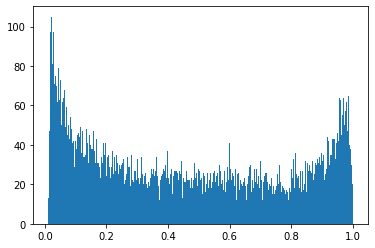

In [6]:
    # print(np.mean(score,tuple(range(1, score.ndim))))
    # all.extend(
    #    [
    #        m["severity"].measurement
    #        for m in meta
    #        if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
    #    ]
    # )

import numpy as np
plt.hist(all, 500)
plt.show()


3 (1, 5) 100
49
49
